In [1]:
%matplotlib inline

In [2]:
import pybedtools
import scipy
import pandas as pd
import numpy as np # need for  stats
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import mannwhitneyu
import os
import pprint

In [3]:
# load modules

import glob
from scipy.stats import wilcoxon
from pybedtools import BedTool
from scipy.stats import spearmanr


In [4]:
#First we need to define the base dirs
DIRS = {}
DIRS['BASE2'] = '/home/anjuni/analysis'
DIRS['FIGURES'] = os.path.join(DIRS['BASE2'], 'figures')


In [5]:
DIRS['COVERAGE'] = os.path.join(DIRS['BASE2'], 'coverage')
DIRS['GENE'] = os.path.join(DIRS['COVERAGE'], 'gene_level')
DIRS['GENE_ANNO'] = os.path.join(DIRS['GENE'], 'gene_anno')
DIRS['BOTH_U_D'] = os.path.join(DIRS['GENE'], 'both_upstream_downstream')
DIRS['DOWN_STR'] = os.path.join(DIRS['GENE'], 'downstream')
DIRS['UP_STR'] = os.path.join(DIRS['GENE'], 'upstream')
DIRS['TSS'] = os.path.join(DIRS['GENE'], 'tss_6mA_only')

In [6]:
DIRS['BASE1'] = '/home/anjuni/methylation_calling/pacbio'

DIRS['BED_INPUT'] = os.path.join(DIRS['BASE2'], 'bedtools_output', 'sequencing_comparison')
DIRS['GFF_INPUT'] = os.path.join(DIRS['BASE2'], 'gff_output')

DIRS['I_FROM_C'] = os.path.join(DIRS['BASE2'], 'bedtools_output', 'intersects_from_cutoffs')
DIRS['BED_CUTOFFS'] = os.path.join(DIRS['BASE1'], 'input', 'sorted_bed_files', 'cutoffs')
DIRS['6MA_CUTOFFS'] = os.path.join(DIRS['BASE1'], 'input', 'sorted_bed_files', 'cutoffs_6mA')
DIRS['5MC_CUTOFFS'] = os.path.join(DIRS['BASE1'], 'input', 'sorted_bed_files', 'cutoffs_5mC')

## Making initial dataframes

In [7]:
# make the dataframes for p and h
h_contig_df = pd.read_csv(os.path.join(DIRS['FIGURES'], 'expression', 'rnaseq_methyl_df_h.tsv'),sep='\t' )
p_contig_df = pd.read_csv(os.path.join(DIRS['FIGURES'], 'expression', 'rnaseq_methyl_df_p.tsv'),sep='\t' )

In [8]:
h_contig_df.head()

,gene_ID,GS,HE,IT0,IT6,IT9,UG,5mC_gene_body_50,6mA_gene_body_50,5mC_upstream_50,...,6mA_tss_50,5mC_gene_body_95,6mA_gene_body_95,5mC_upstream_95,6mA_upstream_95,5mC_downstream_95,6mA_downstream_95,5mC_both_95,6mA_both_95,6mA_tss_95
0,gene_model_hcontig_0000_03.1,0.487427,0.000000,0.000000,0.000000,2.377196,0.384531,0.239374,0.147651,0.213,...,0.148,0.105145,0.040268,0.124,0.034,0.043,0.007,0.0835,0.0205,0.040
1,gene_model_hcontig_0000_03.2,0.577405,144.208849,0.000000,1016.181477,456.791691,0.446980,0.190050,0.110448,0.176,...,0.092,0.000000,0.000000,0.001,0.000,0.000,0.002,0.0005,0.0010,0.000
2,gene_model_hcontig_0000_03.3,564.783136,52.086774,24.713948,235.779282,239.133947,316.475087,0.172863,0.085502,0.148,...,0.090,0.000000,0.001859,0.000,0.001,0.000,0.000,0.0000,0.0005,0.004
3,gene_model_hcontig_0000_03.4,0.000000,0.167865,0.000000,0.115347,0.179739,0.000000,0.224765,0.177230,0.177,...,0.132,0.001761,0.000587,0.003,0.009,0.000,0.003,0.0015,0.0060,0.002
4,EVM prediction%2hcontig_0000_003.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.127193,0.245614,0.134,...,0.250,0.000877,0.000877,0.000,0.003,0.000,0.003,0.0000,0.0030,0.002


In [9]:
p_contig_df.head()

,gene_ID,GS,HE,IT0,IT6,IT9,UG,5mC_gene_body_50,6mA_gene_body_50,5mC_upstream_50,...,6mA_tss_50,5mC_gene_body_95,6mA_gene_body_95,5mC_upstream_95,6mA_upstream_95,5mC_downstream_95,6mA_downstream_95,5mC_both_95,6mA_both_95,6mA_tss_95
0,gene_model_pcontig_000.1,9.272092,0.061132,0.000000,0.000000,0.693499,2.731541,0.232882,0.129151,0.251958,...,0.166,0.070931,0.00779,0.088773,0.016971,0.029,0.007,0.058886,0.011986,0.01
1,gene_model_pcontig_000.2,0.392567,0.198648,0.000000,0.000000,1.925084,0.383660,0.197059,0.120588,0.193000,...,0.128,0.011765,0.00000,0.008000,0.003000,0.000,0.000,0.004000,0.001500,0.00
2,gene_model_pcontig_000.3,0.516801,130.454256,0.000000,950.078729,419.259148,0.395637,0.198405,0.153539,0.171000,...,0.142,0.000997,0.00000,0.001000,0.001000,0.000,0.008,0.000500,0.004500,0.00
3,gene_model_pcontig_000.4,504.229774,46.756651,21.959973,217.808881,219.104632,279.622402,0.233271,0.091078,0.184000,...,0.082,0.000000,0.00000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,0.00
4,gene_model_pcontig_000.5,154.614015,32.043647,0.000000,114.040510,450.072586,197.258316,0.232236,0.082611,0.196000,...,0.072,0.000000,0.00000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,0.00


In [10]:
print(len(p_contig_df))
print(len(h_contig_df))

19348
17199


In [11]:
h_contig_df.columns

Index(['gene_ID', 'GS', 'HE', 'IT0', 'IT6', 'IT9', 'UG', '5mC_gene_body_50',
       '6mA_gene_body_50', '5mC_upstream_50', '6mA_upstream_50',
       '5mC_downstream_50', '6mA_downstream_50', '5mC_both_50', '6mA_both_50',
       '6mA_tss_50', '5mC_gene_body_95', '6mA_gene_body_95', '5mC_upstream_95',
       '6mA_upstream_95', '5mC_downstream_95', '6mA_downstream_95',
       '5mC_both_95', '6mA_both_95', '6mA_tss_95'],
      dtype='object')

In [12]:
p_contig_df.columns

Index(['gene_ID', 'GS', 'HE', 'IT0', 'IT6', 'IT9', 'UG', '5mC_gene_body_50',
       '6mA_gene_body_50', '5mC_upstream_50', '6mA_upstream_50',
       '5mC_downstream_50', '6mA_downstream_50', '5mC_both_50', '6mA_both_50',
       '6mA_tss_50', '5mC_gene_body_95', '6mA_gene_body_95', '5mC_upstream_95',
       '6mA_upstream_95', '5mC_downstream_95', '6mA_downstream_95',
       '5mC_both_95', '6mA_both_95', '6mA_tss_95'],
      dtype='object')

## This adds a protein_ID column at the end of the dataframe for BUSCOs

In [13]:
# This adds a protein_ID column at the end of the dataframe
gff_h_anno_TE_df = pd.read_csv('/home/anjuni/analysis/annotations/Pst_104E_v13_h_ctg.repeatgenesLT.gff3', header=None, sep='\t')
gff_h_anno_df = pd.read_csv('/home/anjuni/analysis/annotations/Pst_104E_v13_h_ctg.anno.gff3', header=None, sep='\t')

name_pattern = re.compile(r'Name=([^;]*)')
id_pattern = re.compile(r'ID=([^;]*)')

Name_id_dict = {}
for key in gff_h_anno_df[gff_h_anno_df[2] == 'gene'][8]:
    Name_id_dict[re.findall(name_pattern, key)[0]] = re.findall(id_pattern, key)[0]
for key in gff_h_anno_TE_df[gff_h_anno_TE_df[2] == 'gene'][8]:
    Name_id_dict[re.findall(name_pattern, key)[0]] = re.findall(id_pattern, key)[0]    
h_contig_df['Protein_ID'] = h_contig_df['gene_ID'].apply(lambda x: Name_id_dict[x])

In [14]:
h_contig_df.head()

,gene_ID,GS,HE,IT0,IT6,IT9,UG,5mC_gene_body_50,6mA_gene_body_50,5mC_upstream_50,...,5mC_gene_body_95,6mA_gene_body_95,5mC_upstream_95,6mA_upstream_95,5mC_downstream_95,6mA_downstream_95,5mC_both_95,6mA_both_95,6mA_tss_95,Protein_ID
0,gene_model_hcontig_0000_03.1,0.487427,0.000000,0.000000,0.000000,2.377196,0.384531,0.239374,0.147651,0.213,...,0.105145,0.040268,0.124,0.034,0.043,0.007,0.0835,0.0205,0.040,evm.TU.hcontig_000_003.1
1,gene_model_hcontig_0000_03.2,0.577405,144.208849,0.000000,1016.181477,456.791691,0.446980,0.190050,0.110448,0.176,...,0.000000,0.000000,0.001,0.000,0.000,0.002,0.0005,0.0010,0.000,evm.TU.hcontig_000_003.2
2,gene_model_hcontig_0000_03.3,564.783136,52.086774,24.713948,235.779282,239.133947,316.475087,0.172863,0.085502,0.148,...,0.000000,0.001859,0.000,0.001,0.000,0.000,0.0000,0.0005,0.004,evm.TU.hcontig_000_003.3
3,gene_model_hcontig_0000_03.4,0.000000,0.167865,0.000000,0.115347,0.179739,0.000000,0.224765,0.177230,0.177,...,0.001761,0.000587,0.003,0.009,0.000,0.003,0.0015,0.0060,0.002,evm.TU.hcontig_000_003.4
4,EVM prediction%2hcontig_0000_003.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.127193,0.245614,0.134,...,0.000877,0.000877,0.000,0.003,0.000,0.003,0.0000,0.0030,0.002,evm.TU.hcontig_000_003.5


In [15]:
gff_p_anno_TE_df = pd.read_csv('/home/anjuni/analysis/annotations/Pst_104E_v13_p_ctg.repeatgenesLT.gff3', header=None, sep='\t')
gff_p_anno_df = pd.read_csv('/home/anjuni/analysis/annotations/Pst_104E_v13_p_ctg.anno.gff3', header=None, sep='\t')

name_pattern = re.compile(r'Name=([^;]*)')
id_pattern = re.compile(r'ID=([^;]*)')

Name_id_dict = {}
for key in gff_p_anno_df[gff_p_anno_df[2] == 'gene'][8]:
    Name_id_dict[re.findall(name_pattern, key)[0]] = re.findall(id_pattern, key)[0]
for key in gff_p_anno_TE_df[gff_p_anno_TE_df[2] == 'gene'][8]:
    Name_id_dict[re.findall(name_pattern, key)[0]] = re.findall(id_pattern, key)[0]
p_contig_df['Protein_ID'] = p_contig_df['gene_ID'].apply(lambda x: Name_id_dict[x])

In [16]:
p_contig_df.head()

,gene_ID,GS,HE,IT0,IT6,IT9,UG,5mC_gene_body_50,6mA_gene_body_50,5mC_upstream_50,...,5mC_gene_body_95,6mA_gene_body_95,5mC_upstream_95,6mA_upstream_95,5mC_downstream_95,6mA_downstream_95,5mC_both_95,6mA_both_95,6mA_tss_95,Protein_ID
0,gene_model_pcontig_000.1,9.272092,0.061132,0.000000,0.000000,0.693499,2.731541,0.232882,0.129151,0.251958,...,0.070931,0.00779,0.088773,0.016971,0.029,0.007,0.058886,0.011986,0.01,evm.TU.pcontig_000.1
1,gene_model_pcontig_000.2,0.392567,0.198648,0.000000,0.000000,1.925084,0.383660,0.197059,0.120588,0.193000,...,0.011765,0.00000,0.008000,0.003000,0.000,0.000,0.004000,0.001500,0.00,evm.TU.pcontig_000.2
2,gene_model_pcontig_000.3,0.516801,130.454256,0.000000,950.078729,419.259148,0.395637,0.198405,0.153539,0.171000,...,0.000997,0.00000,0.001000,0.001000,0.000,0.008,0.000500,0.004500,0.00,evm.TU.pcontig_000.3
3,gene_model_pcontig_000.4,504.229774,46.756651,21.959973,217.808881,219.104632,279.622402,0.233271,0.091078,0.184000,...,0.000000,0.00000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,0.00,evm.TU.pcontig_000.4
4,gene_model_pcontig_000.5,154.614015,32.043647,0.000000,114.040510,450.072586,197.258316,0.232236,0.082611,0.196000,...,0.000000,0.00000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,0.00,evm.TU.pcontig_000.5


## This adds a column for gene type at the end of the dataframe for gene type
- BUSCOs, effectors, TEs, all genes, non-TE genes, all genes

In [17]:
# get a list of genes in each gene type category and add the column

#add file paths
GENE_BED_FOLDER = '/home/anjuni/beds/'
busco_gene_bed_h = 'Pst_104E_v12_h_busco.gene.bed'
effector_gene_bed_h = 'Pst_104E_v12_h_effector.gene.bed'
TE_list_h = []
for key in gff_h_anno_TE_df[gff_h_anno_TE_df[2] == 'gene'][8]:
    TE_list_h.append(re.findall(id_pattern, key)[0])

# make a list
BUSCO_list_h = pd.read_csv(os.path.join(GENE_BED_FOLDER, busco_gene_bed_h), sep='\t', header=None)[3].tolist()
effector_list_h = pd.read_csv(os.path.join(GENE_BED_FOLDER, effector_gene_bed_h), sep='\t', header=None)[3].tolist()

# add values to column
h_contig_df['Gene_type'] = 'All genes'
h_contig_df.loc[h_contig_df.Protein_ID.isin(effector_list_h), 'Gene_type'] = 'Effector'
h_contig_df.loc[h_contig_df.Protein_ID.isin(BUSCO_list_h), 'Gene_type'] = 'BUSCO'
h_contig_df.loc[h_contig_df.Protein_ID.isin(TE_list_h), 'Gene_type'] = 'TE gene'

In [18]:
h_contig_df.head()

,gene_ID,GS,HE,IT0,IT6,IT9,UG,5mC_gene_body_50,6mA_gene_body_50,5mC_upstream_50,...,6mA_gene_body_95,5mC_upstream_95,6mA_upstream_95,5mC_downstream_95,6mA_downstream_95,5mC_both_95,6mA_both_95,6mA_tss_95,Protein_ID,Gene_type
0,gene_model_hcontig_0000_03.1,0.487427,0.000000,0.000000,0.000000,2.377196,0.384531,0.239374,0.147651,0.213,...,0.040268,0.124,0.034,0.043,0.007,0.0835,0.0205,0.040,evm.TU.hcontig_000_003.1,Effector
1,gene_model_hcontig_0000_03.2,0.577405,144.208849,0.000000,1016.181477,456.791691,0.446980,0.190050,0.110448,0.176,...,0.000000,0.001,0.000,0.000,0.002,0.0005,0.0010,0.000,evm.TU.hcontig_000_003.2,Effector
2,gene_model_hcontig_0000_03.3,564.783136,52.086774,24.713948,235.779282,239.133947,316.475087,0.172863,0.085502,0.148,...,0.001859,0.000,0.001,0.000,0.000,0.0000,0.0005,0.004,evm.TU.hcontig_000_003.3,All genes
3,gene_model_hcontig_0000_03.4,0.000000,0.167865,0.000000,0.115347,0.179739,0.000000,0.224765,0.177230,0.177,...,0.000587,0.003,0.009,0.000,0.003,0.0015,0.0060,0.002,evm.TU.hcontig_000_003.4,All genes
4,EVM prediction%2hcontig_0000_003.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.127193,0.245614,0.134,...,0.000877,0.000,0.003,0.000,0.003,0.0000,0.0030,0.002,evm.TU.hcontig_000_003.5,TE gene


In [19]:
# get a list of genes in each gene type category and add the column

#add file paths

busco_gene_bed_p = 'Pst_104E_v12_p_busco.gene.bed'
effector_gene_bed_p = 'Pst_104E_v12_p_effector.gene.bed'
TE_list_p = []
for key in gff_p_anno_TE_df[gff_p_anno_TE_df[2] == 'gene'][8]:
    TE_list_p.append(re.findall(id_pattern, key)[0])
#s.listdir(GENE_BED_FOLDER)

# make a list
BUSCO_list_p = pd.read_csv(os.path.join(GENE_BED_FOLDER, busco_gene_bed_p), sep='\t', header=None)[3].tolist()
effector_list_p = pd.read_csv(os.path.join(GENE_BED_FOLDER, effector_gene_bed_p), sep='\t', header=None)[3].tolist()

# add values to column
p_contig_df['Gene_type'] = 'All genes'
p_contig_df.loc[p_contig_df.Protein_ID.isin(effector_list_p), 'Gene_type'] = 'Effector'
p_contig_df.loc[p_contig_df.Protein_ID.isin(BUSCO_list_p), 'Gene_type'] = 'BUSCO'
p_contig_df.loc[p_contig_df.Protein_ID.isin(TE_list_p), 'Gene_type'] = 'TE gene'

In [20]:
p_contig_df.head()

,gene_ID,GS,HE,IT0,IT6,IT9,UG,5mC_gene_body_50,6mA_gene_body_50,5mC_upstream_50,...,6mA_gene_body_95,5mC_upstream_95,6mA_upstream_95,5mC_downstream_95,6mA_downstream_95,5mC_both_95,6mA_both_95,6mA_tss_95,Protein_ID,Gene_type
0,gene_model_pcontig_000.1,9.272092,0.061132,0.000000,0.000000,0.693499,2.731541,0.232882,0.129151,0.251958,...,0.00779,0.088773,0.016971,0.029,0.007,0.058886,0.011986,0.01,evm.TU.pcontig_000.1,All genes
1,gene_model_pcontig_000.2,0.392567,0.198648,0.000000,0.000000,1.925084,0.383660,0.197059,0.120588,0.193000,...,0.00000,0.008000,0.003000,0.000,0.000,0.004000,0.001500,0.00,evm.TU.pcontig_000.2,All genes
2,gene_model_pcontig_000.3,0.516801,130.454256,0.000000,950.078729,419.259148,0.395637,0.198405,0.153539,0.171000,...,0.00000,0.001000,0.001000,0.000,0.008,0.000500,0.004500,0.00,evm.TU.pcontig_000.3,Effector
3,gene_model_pcontig_000.4,504.229774,46.756651,21.959973,217.808881,219.104632,279.622402,0.233271,0.091078,0.184000,...,0.00000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,0.00,evm.TU.pcontig_000.4,All genes
4,gene_model_pcontig_000.5,154.614015,32.043647,0.000000,114.040510,450.072586,197.258316,0.232236,0.082611,0.196000,...,0.00000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,0.00,evm.TU.pcontig_000.5,All genes


## This adds a columns at the end of the dataframe for the top 500 genes for each methylation type

- top 500 5mc gene body
- top 500 5mc upstream
- top 500 5mc downstream
- top 500 5mc both
- top 500 6ma tss

In [21]:
###This is the index of all highly methylated genes
#get a true false column for plotting and analysis
h_contig_df["Top_500_5mC_gene_body_50"] = "Lowly methylated"
h_contig_df.loc[h_contig_df.sort_values(by='5mC_gene_body_50', ascending=False).loc[:500].index,"Top_500_5mC_gene_body_50"] = "Highly methylated"

h_contig_df["Top_500_5mC_upstream_50"] = "Lowly methylated"
h_contig_df.loc[h_contig_df.sort_values(by='5mC_upstream_50', ascending=False).loc[:500].index,"Top_500_5mC_upstream_50"] = "Highly methylated"

h_contig_df["Top_500_5mC_downstream_50"] = "Lowly methylated"
h_contig_df.loc[h_contig_df.sort_values(by='5mC_downstream_50', ascending=False).loc[:500].index,"Top_500_5mC_downstream_50"] = "Highly methylated"

h_contig_df["Top_500_5mC_both_50"] = "Lowly methylated"
h_contig_df.loc[h_contig_df.sort_values(by='5mC_both_50', ascending=False).loc[:500].index,"Top_500_5mC_both_50"] = "Highly methylated"

h_contig_df["Top_500_6mA_tss_50"] = "Lowly methylated"
h_contig_df.loc[h_contig_df.sort_values(by='6mA_tss_50', ascending=False).loc[:500].index,"Top_500_6mA_tss_50"] = "Highly methylated"

In [22]:
###This is the index of all highly methylated genes
#get a true false column for plotting and analysis
h_contig_df["Top_500_5mC_gene_body_50"] = "Low"
h_contig_df.loc[h_contig_df.sort_values(by='5mC_gene_body_50', ascending=False).loc[:500].index,"Top_500_5mC_gene_body_50"] = "High"

h_contig_df["Top_500_5mC_upstream_50"] = "Low"
h_contig_df.loc[h_contig_df.sort_values(by='5mC_upstream_50', ascending=False).loc[:500].index,"Top_500_5mC_upstream_50"] = "High"

h_contig_df["Top_500_5mC_downstream_50"] = "Low"
h_contig_df.loc[h_contig_df.sort_values(by='5mC_downstream_50', ascending=False).loc[:500].index,"Top_500_5mC_downstream_50"] = "High"

h_contig_df["Top_500_5mC_both_50"] = "Low"
h_contig_df.loc[h_contig_df.sort_values(by='5mC_both_50', ascending=False).loc[:500].index,"Top_500_5mC_both_50"] = "High"

h_contig_df["Top_500_6mA_tss_50"] = "Low"
h_contig_df.loc[h_contig_df.sort_values(by='6mA_tss_50', ascending=False).loc[:500].index,"Top_500_6mA_tss_50"] = "High"

In [23]:
h_contig_df.head()

,gene_ID,GS,HE,IT0,IT6,IT9,UG,5mC_gene_body_50,6mA_gene_body_50,5mC_upstream_50,...,5mC_both_95,6mA_both_95,6mA_tss_95,Protein_ID,Gene_type,Top_500_5mC_gene_body_50,Top_500_5mC_upstream_50,Top_500_5mC_downstream_50,Top_500_5mC_both_50,Top_500_6mA_tss_50
0,gene_model_hcontig_0000_03.1,0.487427,0.000000,0.000000,0.000000,2.377196,0.384531,0.239374,0.147651,0.213,...,0.0835,0.0205,0.040,evm.TU.hcontig_000_003.1,Effector,High,High,High,High,High
1,gene_model_hcontig_0000_03.2,0.577405,144.208849,0.000000,1016.181477,456.791691,0.446980,0.190050,0.110448,0.176,...,0.0005,0.0010,0.000,evm.TU.hcontig_000_003.2,Effector,High,High,High,High,High
2,gene_model_hcontig_0000_03.3,564.783136,52.086774,24.713948,235.779282,239.133947,316.475087,0.172863,0.085502,0.148,...,0.0000,0.0005,0.004,evm.TU.hcontig_000_003.3,All genes,High,High,High,High,High
3,gene_model_hcontig_0000_03.4,0.000000,0.167865,0.000000,0.115347,0.179739,0.000000,0.224765,0.177230,0.177,...,0.0015,0.0060,0.002,evm.TU.hcontig_000_003.4,All genes,High,High,High,High,High
4,EVM prediction%2hcontig_0000_003.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.127193,0.245614,0.134,...,0.0000,0.0030,0.002,evm.TU.hcontig_000_003.5,TE gene,High,High,High,High,High


In [24]:
###This is the index of all highly methylated genes
#get a true false column for plotting and analysis
p_contig_df["Top_500_5mC_gene_body_50"] = "Lowly methylated"
p_contig_df.loc[p_contig_df.sort_values(by='5mC_gene_body_50', ascending=False).loc[:500].index,"Top_500_5mC_gene_body_50"] = "Highly methylated"

p_contig_df["Top_500_5mC_upstream_50"] = "Lowly methylated"
p_contig_df.loc[p_contig_df.sort_values(by='5mC_upstream_50', ascending=False).loc[:500].index,"Top_500_5mC_upstream_50"] = "Highly methylated"

p_contig_df["Top_500_5mC_downstream_50"] = "Lowly methylated"
p_contig_df.loc[p_contig_df.sort_values(by='5mC_downstream_50', ascending=False).loc[:500].index,"Top_500_5mC_downstream_50"] = "Highly methylated"

p_contig_df["Top_500_5mC_both_50"] = "Lowly methylated"
p_contig_df.loc[p_contig_df.sort_values(by='5mC_both_50', ascending=False).loc[:500].index,"Top_500_5mC_both_50"] = "Highly methylated"

p_contig_df["Top_500_6mA_tss_50"] = "Lowly methylated"
p_contig_df.loc[p_contig_df.sort_values(by='6mA_tss_50', ascending=False).loc[:500].index,"Top_500_6mA_tss_50"] = "Highly methylated"

In [25]:
###This is the index of all highly methylated genes
#get a true false column for plotting and analysis
p_contig_df["Top_500_5mC_gene_body_50"] = "Low"
p_contig_df.loc[p_contig_df.sort_values(by='5mC_gene_body_50', ascending=False).loc[:500].index,"Top_500_5mC_gene_body_50"] = "High"

p_contig_df["Top_500_5mC_upstream_50"] = "Low"
p_contig_df.loc[p_contig_df.sort_values(by='5mC_upstream_50', ascending=False).loc[:500].index,"Top_500_5mC_upstream_50"] = "High"

p_contig_df["Top_500_5mC_downstream_50"] = "Low"
p_contig_df.loc[p_contig_df.sort_values(by='5mC_downstream_50', ascending=False).loc[:500].index,"Top_500_5mC_downstream_50"] = "High"

p_contig_df["Top_500_5mC_both_50"] = "Low"
p_contig_df.loc[p_contig_df.sort_values(by='5mC_both_50', ascending=False).loc[:500].index,"Top_500_5mC_both_50"] = "High"

p_contig_df["Top_500_6mA_tss_50"] = "Low"
p_contig_df.loc[p_contig_df.sort_values(by='6mA_tss_50', ascending=False).loc[:500].index,"Top_500_6mA_tss_50"] = "High"

In [26]:
p_contig_df.head()

,gene_ID,GS,HE,IT0,IT6,IT9,UG,5mC_gene_body_50,6mA_gene_body_50,5mC_upstream_50,...,5mC_both_95,6mA_both_95,6mA_tss_95,Protein_ID,Gene_type,Top_500_5mC_gene_body_50,Top_500_5mC_upstream_50,Top_500_5mC_downstream_50,Top_500_5mC_both_50,Top_500_6mA_tss_50
0,gene_model_pcontig_000.1,9.272092,0.061132,0.000000,0.000000,0.693499,2.731541,0.232882,0.129151,0.251958,...,0.058886,0.011986,0.01,evm.TU.pcontig_000.1,All genes,High,High,High,High,High
1,gene_model_pcontig_000.2,0.392567,0.198648,0.000000,0.000000,1.925084,0.383660,0.197059,0.120588,0.193000,...,0.004000,0.001500,0.00,evm.TU.pcontig_000.2,All genes,High,High,High,High,High
2,gene_model_pcontig_000.3,0.516801,130.454256,0.000000,950.078729,419.259148,0.395637,0.198405,0.153539,0.171000,...,0.000500,0.004500,0.00,evm.TU.pcontig_000.3,Effector,High,High,High,High,High
3,gene_model_pcontig_000.4,504.229774,46.756651,21.959973,217.808881,219.104632,279.622402,0.233271,0.091078,0.184000,...,0.000000,0.000000,0.00,evm.TU.pcontig_000.4,All genes,High,High,High,High,High
4,gene_model_pcontig_000.5,154.614015,32.043647,0.000000,114.040510,450.072586,197.258316,0.232236,0.082611,0.196000,...,0.000000,0.000000,0.00,evm.TU.pcontig_000.5,All genes,High,High,High,High,High


In [27]:
#add 0.1 for log transformation
h_contig_df['UG_01'] = h_contig_df['UG'] + 0.1
h_contig_df['HE_01'] = h_contig_df['HE'] + 0.1
h_contig_df['IT6_01'] = h_contig_df['IT6'] + 0.1
h_contig_df['IT9_01'] = h_contig_df['IT9'] + 0.1

p_contig_df['UG_01'] = h_contig_df['UG'] + 0.1
p_contig_df['HE_01'] = h_contig_df['HE'] + 0.1
p_contig_df['IT6_01'] = h_contig_df['IT6'] + 0.1
p_contig_df['IT9_01'] = h_contig_df['IT9'] + 0.1

In [28]:
h_contig_df.head()

,gene_ID,GS,HE,IT0,IT6,IT9,UG,5mC_gene_body_50,6mA_gene_body_50,5mC_upstream_50,...,Gene_type,Top_500_5mC_gene_body_50,Top_500_5mC_upstream_50,Top_500_5mC_downstream_50,Top_500_5mC_both_50,Top_500_6mA_tss_50,UG_01,HE_01,IT6_01,IT9_01
0,gene_model_hcontig_0000_03.1,0.487427,0.000000,0.000000,0.000000,2.377196,0.384531,0.239374,0.147651,0.213,...,Effector,High,High,High,High,High,0.484531,0.100000,0.100000,2.477196
1,gene_model_hcontig_0000_03.2,0.577405,144.208849,0.000000,1016.181477,456.791691,0.446980,0.190050,0.110448,0.176,...,Effector,High,High,High,High,High,0.546980,144.308849,1016.281477,456.891691
2,gene_model_hcontig_0000_03.3,564.783136,52.086774,24.713948,235.779282,239.133947,316.475087,0.172863,0.085502,0.148,...,All genes,High,High,High,High,High,316.575087,52.186774,235.879282,239.233947
3,gene_model_hcontig_0000_03.4,0.000000,0.167865,0.000000,0.115347,0.179739,0.000000,0.224765,0.177230,0.177,...,All genes,High,High,High,High,High,0.100000,0.267865,0.215347,0.279739
4,EVM prediction%2hcontig_0000_003.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.127193,0.245614,0.134,...,TE gene,High,High,High,High,High,0.100000,0.100000,0.100000,0.100000


In [29]:
p_contig_df.head()

,gene_ID,GS,HE,IT0,IT6,IT9,UG,5mC_gene_body_50,6mA_gene_body_50,5mC_upstream_50,...,Gene_type,Top_500_5mC_gene_body_50,Top_500_5mC_upstream_50,Top_500_5mC_downstream_50,Top_500_5mC_both_50,Top_500_6mA_tss_50,UG_01,HE_01,IT6_01,IT9_01
0,gene_model_pcontig_000.1,9.272092,0.061132,0.000000,0.000000,0.693499,2.731541,0.232882,0.129151,0.251958,...,All genes,High,High,High,High,High,0.484531,0.100000,0.100000,2.477196
1,gene_model_pcontig_000.2,0.392567,0.198648,0.000000,0.000000,1.925084,0.383660,0.197059,0.120588,0.193000,...,All genes,High,High,High,High,High,0.546980,144.308849,1016.281477,456.891691
2,gene_model_pcontig_000.3,0.516801,130.454256,0.000000,950.078729,419.259148,0.395637,0.198405,0.153539,0.171000,...,Effector,High,High,High,High,High,316.575087,52.186774,235.879282,239.233947
3,gene_model_pcontig_000.4,504.229774,46.756651,21.959973,217.808881,219.104632,279.622402,0.233271,0.091078,0.184000,...,All genes,High,High,High,High,High,0.100000,0.267865,0.215347,0.279739
4,gene_model_pcontig_000.5,154.614015,32.043647,0.000000,114.040510,450.072586,197.258316,0.232236,0.082611,0.196000,...,All genes,High,High,High,High,High,0.100000,0.100000,0.100000,0.100000


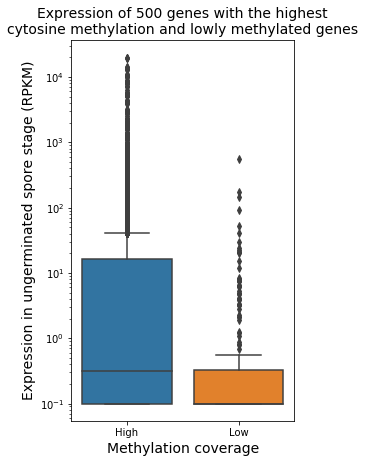

In [30]:
#quick plot for comparing expression of highly methylated genes versus the rest
f, ax = plt.subplots(figsize=(4, 7))
ax.set_yscale("log")
sns.boxplot(y='UG_01', x="Top_500_5mC_gene_body_50", data=h_contig_df)
#title = 'Expression of 500 most highly methylated genes' + '\n' and the lowly methylated genes'
plt.title('Expression of 500 genes with the highest\ncytosine methylation and lowly methylated genes',fontsize=14)
plt.ylabel('Expression in ungerminated spore stage (RPKM)', fontsize=14)
plt.xlabel('Methylation coverage', fontsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.savefig('testfig2.png', bbox_inches='tight')

In [31]:
#do some quick stats if those are different from each other
mannwhitneyu(h_contig_df[h_contig_df["Top_500_5mC_gene_body_50"] == 'Low']['UG_01'],h_contig_df[h_contig_df["Top_500_5mC_gene_body_50"] == 'High']['UG_01'] )

MannwhitneyuResult(statistic=1208273.5, pvalue=3.5252246099440555e-17)

In [32]:
mwu_dict = {}

In [47]:
# function to make graph and save out dictionary of mann whitney u
def top500_plot(df, col, mod):
    f, ax = plt.subplots(figsize=(4, 7))
    ax.set_yscale("log")
    sns.boxplot(y='UG_01', x=col, data=df)
    name = 'Expression of 500 genes with the highest' + '\n' + mod + '\n' + 'and all other genes'
    plt.title(name, fontsize=14)
    plt.ylabel('Expression in ungerminated spore stage (RPKM)', fontsize=14)
    plt.xlabel('Methylation coverage', fontsize=14)
    plt.rc('xtick', labelsize=14)
    plt.rc('ytick', labelsize=14)
    name = mod + '.png'
    outfn = col + '.png'
    outfn = os.path.join(DIRS['FIGURES'], 'expression', outfn)
    plt.savefig(outfn, bbox_inches='tight')
    mwu_dict[mod] = mannwhitneyu(df[df[col] == 'Low']['UG_01'],df[df[col] == 'High']['UG_01'] )

In [36]:
df = h_contig_df
col = '5mC_gene_body_50'
mod = 'gene body 5mC methylation'

In [48]:
name = 'Expression of 500 genes with the highest' + '\n' + mod + '\n' + 'and all other genes'
print(name)

Expression of 500 genes with the highest
gene body 5mC methylation
and all other genes


In [46]:
outfn = col + '.png'
outfn = os.path.join(DIRS['FIGURES'], 'expression', outfn)
outfn

'/home/anjuni/analysis/figures/expression/5mC_gene_body_50.png'

In [41]:
df.head()

,gene_ID,GS,HE,IT0,IT6,IT9,UG,5mC_gene_body_50,6mA_gene_body_50,5mC_upstream_50,...,Gene_type,Top_500_5mC_gene_body_50,Top_500_5mC_upstream_50,Top_500_5mC_downstream_50,Top_500_5mC_both_50,Top_500_6mA_tss_50,UG_01,HE_01,IT6_01,IT9_01
0,gene_model_hcontig_0000_03.1,0.487427,0.000000,0.000000,0.000000,2.377196,0.384531,0.239374,0.147651,0.213,...,Effector,High,High,High,High,High,0.484531,0.100000,0.100000,2.477196
1,gene_model_hcontig_0000_03.2,0.577405,144.208849,0.000000,1016.181477,456.791691,0.446980,0.190050,0.110448,0.176,...,Effector,High,High,High,High,High,0.546980,144.308849,1016.281477,456.891691
2,gene_model_hcontig_0000_03.3,564.783136,52.086774,24.713948,235.779282,239.133947,316.475087,0.172863,0.085502,0.148,...,All genes,High,High,High,High,High,316.575087,52.186774,235.879282,239.233947
3,gene_model_hcontig_0000_03.4,0.000000,0.167865,0.000000,0.115347,0.179739,0.000000,0.224765,0.177230,0.177,...,All genes,High,High,High,High,High,0.100000,0.267865,0.215347,0.279739
4,EVM prediction%2hcontig_0000_003.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.127193,0.245614,0.134,...,TE gene,High,High,High,High,High,0.100000,0.100000,0.100000,0.100000


In [ ]:
h_contig_df.columns

In [ ]:
# run the plots for each type: 5mc up, down, both, gene body, 6ma tss
top500_plot(h_contig_df, '5mC_gene_body_50', 'gene body 5mC methylation')
top500_plot(h_contig_df, '5mC_upstream_50', 'upstream 5mC methylation')
top500_plot(h_contig_df, '5mC_downstream_50', 'downstream 5mC methylation')
top500_plot(h_contig_df, '5mC_both_50', 'upstream and downstream 5mC methylation')
top500_plot(h_contig_df, '6mA_tss_50', 'transcription start site 6mA methylation')

## Gene types

In [ ]:
def genetypelog_plot(df, col, mod):
    f, ax = plt.subplots(figsize=(4, 7))
    ax.set_yscale("log")
    sns.boxplot(y=col, x='Gene_type', data=df)
    title = mod + '\n' + 'of gene types'
    plt.title(title,fontsize=14)
    plt.ylabel('Methylation coverage level', fontsize=14)
    plt.xlabel('Gene type', fontsize=14)
    plt.rc('xtick', labelsize=14)
    plt.rc('ytick', labelsize=14)
    plt.savefig('testfig2.png', bbox_inches='tight')

In [ ]:
def genetype_plot(df, col, mod):
    f, ax = plt.subplots(figsize=(4, 7))
    sns.boxplot(y=col, x='Gene_type', data=df)
    title = mod + '\n' + 'of gene types'
    plt.title(title,fontsize=14)
    plt.ylabel('Methylation coverage level', fontsize=14)
    plt.xlabel('Gene type', fontsize=14)
    plt.rc('xtick', labelsize=14)
    plt.rc('ytick', labelsize=14)
    plt.savefig('testfig2.png', bbox_inches='tight')

In [ ]:
f, ax = plt.subplots(figsize=(7, 6))
ax.set_yscale("log")
sns.boxplot(y='5mC_gene_body_50', x='Gene_type', data=h_contig_df)
plt.title('5mC Gene body methylation of gene types',fontsize=14)
plt.xlabel('Gene type', fontsize=14)
plt.ylabel('Methylation coverage level', fontsize=14)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.savefig('testfig3.png', bbox_inches='tight')

In [ ]:
f, ax = plt.subplots(figsize=(6, 6))
ax.set_yscale("log")
sns.boxplot(y='UG_01', x='Gene_type', data=h_contig_df)
plt.title('Gene expression in ungerminated spore stage of gene types',fontsize=14)
plt.xlabel('Gene type', fontsize=14)
plt.ylabel('Gene expression during ungerminated spore stage (RPKM)', fontsize=14)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.savefig('testfig4.png', bbox_inches='tight')

In [ ]:
h_contig_df.loc[h_contig_df.Protein_ID.isin(effctor_list), 'Effector'] = 'True'
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")
sns.boxplot(x='HE_01', y='Gene_type', data=h_contig_df)

In [ ]:
for x in ['5mC_gene_body_50',
       '6mA_gene_body_50', '5mC_upstream_50', '6mA_upstream_50',
       '5mC_upstream_50.1', '6mA_upstream_50.1', '5mC_downstream_50',
       '6mA_downstream_50', '5mC_gene_body_95', '6mA_gene_body_95',
       '5mC_upstream_95', '6mA_upstream_95', '5mC_downstream_95',
       '6mA_downstream_95']:
    print(x)
    f, ax = plt.subplots(figsize=(7, 6))
    #ax.set_xscale("log")
    sns.boxplot(x=x, y='Gene_type', data=h_contig_df)
    plt.title(x)

In [ ]:
for x in [ '5mC_gene_body_95', '6mA_gene_body_95',
       '5mC_upstream_95', '6mA_upstream_95', '5mC_downstream_95',
       '6mA_downstream_95']:
    print(x)
    f, ax = plt.subplots(figsize=(7, 6))
    #ax.set_xscale("log")
    ax.set_xlim(-0.1,0.1)
    sns.boxplot(x=x, y='Gene_type', data=h_contig_df)
    plt.title(x)